# Lesson 0041 - MNIST Autoencoder
In lessons [0039](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0039_the_bible_word_cloud.ipynb) and [0040](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0040_the_bible_word_cloud_2.ipynb), we mapped high dimensional data to a $2$-dimensional space.<br>
In this lesson, we will do the same with the [MNIST data set](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0010_mnist_classification_linear_classifier.ipynb).<br>
For this, we will construct an __autoencoder__. An __autoencoder__ is the combination of an __encoder__ $f$ and a __decoder__ $g$, so that $g \left( f \left( x \right) \right) \approx x$.<br>
We start with stealing code from [lesson 0035](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0035_mnist_classification_inception_module.ipynb).

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma




train_x = np.reshape( train_x, [ 60000, 28, 28, 1 ] )

test_x = np.reshape( test_x, [ 10000, 28, 28, 1 ] )

In [6]:
import keras
from keras import models
from keras import layers

print( keras.__version__ )

2.2.4


Using TensorFlow backend.


Now, we will build the __encoder__.<br>
We create a simple convolutional neural network with $64$ $5*5$ filters in two consecutive convolutional layers, then a max pooling layer, and then again two consecutive convolutional layers. Then, we flatten the data, and condense the data to a dense layer with $2$ neurons.

In [7]:
input_encoder = keras.engine.input_layer.Input( shape = ( 28, 28, 1, ) )

encoder_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder_layer3 = layers.MaxPooling2D()( encoder_layer2 )

encoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer3 )

encoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer4 )

encoder_layer6 = layers.Flatten()( encoder_layer5 )

encoder_layer7 = layers.Dense( 2, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer6 )

encoder = keras.Model( input_encoder, encoder_layer7 )

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          102464    
_________________________________________________________________
flat

C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Now, we build the __decoder__.<br>
We take as input a $2$-dimensional data set, then we map this data set to a dense layer of $28 * 28$ cells. This is then [reshaped](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) to a $4$-dimensional tensor with $28 * 28 * 1 *$ entries. We then apply to this two consecutive convolutional layers of $64$ $5*5$ filters with ["SAME" padding](https://keras.io/layers/convolutional/) because we want to keep the $28*28$ image size. We then apply one single convolutional layer with one $5*5$ filter to this.

In [8]:
input_decoder = keras.engine.input_layer.Input( shape = ( 2, ) )

decoder_layer1 = layers.Dense( 28 * 28, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Reshape( ( 28, 28, 1, ) )( decoder_layer1 )

decoder_layer3 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer2 )

decoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer3 )

decoder_layer5 = layers.Conv2D( 1, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer4 )

decoder = keras.Model( input_decoder, decoder_layer5 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         1601      
Total params: 108,081
Trainable params: 108,081
Non-trainable params: 0
_________________________________________________________________


Now, we can define the __autoencoder__.

In [9]:
autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 309570    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         108081    
Total params: 417,651
Trainable params: 417,651
Non-trainable params: 0
_________________________________________________________________


And now, we can fit the __autoencoder__.<br>
We employ the [mean squared error](https://keras.io/losses/) as __loss__, because we want to minimize the error between the input image and the output image.

In [10]:
autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.1, momentum = 0.0, decay = 0.0, nesterov = False ),
               loss = "mean_squared_error", metrics = None )

autoencoder.fit( train_x, train_x, validation_data = ( test_x, test_x ), batch_size = 100, epochs = 200 )

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.9138 - val_loss: 0.7220
Epoch 2/200
60000/60000 [==============================] - 10s 173us/step - loss: 0.6250 - val_loss: 0.5971
Epoch 3/200
60000/60000 [==============================] - 10s 174us/step - loss: 0.5929 - val_loss: 0.5804
Epoch 4/200
60000/60000 [==============================] - 10s 174us/step - loss: 0.5782 - val_loss: 0.5692
Epoch 5/200
60000/60000 [==============================] - 10s 174us/step - loss: 0.5653 - val_loss: 0.5567
Epoch 6/200
60000/60000 [==============================] - 10s 174us/step - loss: 0.5532 - val_loss: 0.5447
Epoch 7/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.5411 - val_loss: 0.5365
Epoch 8/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.5305 - val_loss: 0.5217
Epoch 9/200
60000/60000 [=============

60000/60000 [==============================] - 10s 175us/step - loss: 0.3947 - val_loss: 0.4112
Epoch 148/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3945 - val_loss: 0.4046
Epoch 149/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3945 - val_loss: 0.4054
Epoch 150/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3946 - val_loss: 0.4034
Epoch 151/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3943 - val_loss: 0.4048
Epoch 152/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3942 - val_loss: 0.4065
Epoch 153/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3935 - val_loss: 0.4085
Epoch 154/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3932 - val_loss: 0.4186
Epoch 155/200
60000/60000 [==============================] - 10s 175us/step - loss: 0.3933 - val_loss: 0.4059
Epoch 156/200
60000/6000

Now, we generate two arrays of numbers between $-4$ and $4$ with $30$ entries each.<br>
We then generate the image produced by the __decoder__ to every combination of these two arrays and print these images.

Text(0, 0.5, 'Y Axis (-)')

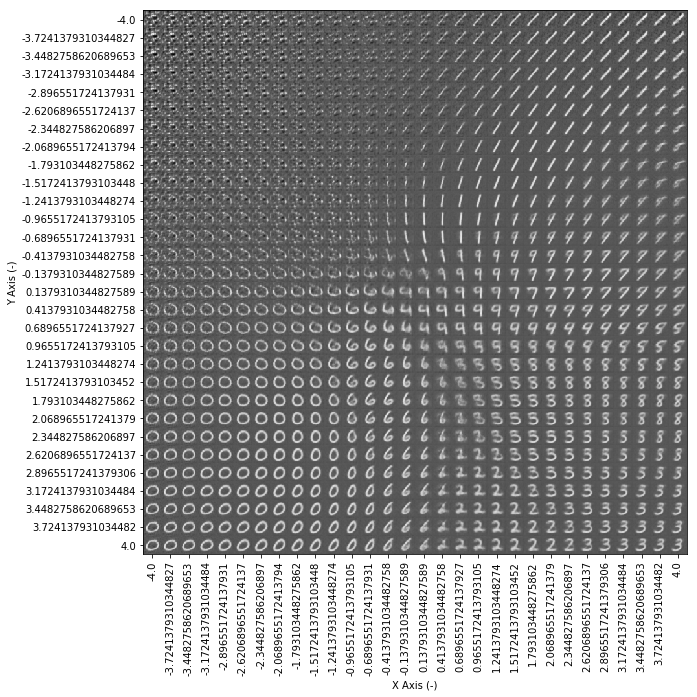

In [11]:
x_axis = np.linspace( -4.0, 4.0, 30 )

y_axis = np.linspace( -4.0, 4.0, 30 )

mat = np.zeros( shape = [ 28 * 30, 28 * 30 ] )




for i in range( 30 ):
    
    for j in range( 30 ):
        
        image = decoder.predict( np.array( [ x_axis[ i ], y_axis[ j ] ] ).reshape( [ 1, 2 ] ) )[ 0 ]
        
        up = j * 28
        
        down = up + 28
        
        left = i * 28
        
        right = left + 28
        
        mat[ up : down, left : right ] = image[ :, :, 0 ]
        
        
        
        
plt.figure( figsize = ( 10, 10 ) )

plt.imshow( mat, cmap = "Greys_r" )

ticks = [ i * 28 + 14 for i in range( 30 ) ]

plt.xticks( ticks, x_axis, rotation = 90 )

plt.yticks( ticks, y_axis )

plt.xlabel( "X Axis (-)" )

plt.ylabel( "Y Axis (-)" )

The image above tells us, that we successfully mapped the $28*28$ pixel images to a $2$-dimensional feature space, from which we can reconstruct the $28*28$ pixel images.<br>
In a more general sense, this can be applied to the following: one could create an __autoencoder__ on a set of images of faces, and within the response of the __encoder__ one could determine the vector that separates a neutral face from a smiling face. Therefore, one could map a neutral face using the __encoder__, add that vector, then a apply the __decoder__ and get an image of a smiling face. Or, one could train an __autoencoder__ on a text in English and French. Then, one could perform the same task as with the neutral face, but in this case, one would actually perform translation.<br>
Class dismissed.